In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
%cd F:\Oguz\EISSA\yeni_cok_kanal7
model_name= 'EEMF_Net-SL16-WO_Mem-res_18-AdamW-OR_False-20250101_21_15_34'


F:\Oguz\EISSA\yeni_cok_kanal7


In [3]:
from data import create_dataset, create_dataloader
from sklearn.metrics import roc_auc_score
from metrics import compute_pro, trapezoid
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import classification_report

import os
import torch
from omegaconf import OmegaConf
from timm import create_model
from models import EEMFNet
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from glob import glob

cfg = OmegaConf.load(r'.\configs.yaml')



target_name = model_name.split('-')[1]
save_dir = fr'{os.getcwd()}\saved_model\{model_name}'


file_list_test = glob(os.path.join(cfg.DATASET.datadir, target_name, r'test\*\*'))


testset = create_dataset(
    file_list              = file_list_test,
    datadir                = cfg['DATASET']['datadir'],
    target                 = target_name, 
    is_train               = False,
    resize                 = cfg['DATASET']['resize'],
    texture_source_dir     = cfg['DATASET']['texture_source_dir'],
    structure_grid_size    = cfg['DATASET']['structure_grid_size'],
    transparency_range     = cfg['DATASET']['transparency_range'],
    perlin_scale           = cfg['DATASET']['perlin_scale'], 
    min_perlin_scale       = cfg['DATASET']['min_perlin_scale'], 
    perlin_noise_threshold = cfg['DATASET']['perlin_noise_threshold']
)

testloader = create_dataloader(
        dataset     = testset,
        train       = False,
        batch_size  = cfg.DATALOADER.batch_size,
        num_workers = cfg.DATALOADER.num_workers
    )

# memory_bank = torch.load(fr'{os.getcwd()}\saved_model\{model_name}\memory_bank.pt', map_location=torch.device('cpu'))
# memory_bank.device = 'cpu'
# for k in memory_bank.memory_information.keys():
#     memory_bank.memory_information[k] = memory_bank.memory_information[k].cpu()

feature_extractor = feature_extractor = create_model(
    'resnet18', 
    pretrained    = True, 
    features_only = True
)

# feature_extractor1 = create_model(
#     cfg.MODEL.feature_extractor_name, 
#     pretrained    = True, 
#     features_only = True
# )
# feature_extractor1.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


model = EEMFNet(
    # memory_bank       = memory_bank,
    feature_extractor = feature_extractor,
    # feature_extractor1 = feature_extractor1
)
model.load_state_dict(torch.load(fr'{os.getcwd()}\saved_model\{model_name}\best_model.pt', map_location=torch.device('cpu')))
model.eval()

F:\Oguz\ProgramData\Temp\2\ipykernel_19952\1877635737.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fr'{os.getcwd()}\saved_model\{mod

EEMFNet(
  (feature_extractor): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [4]:
import time
import torch.nn.functional as F


image_targets = []
image_masks = []
anomaly_score = []
anomaly_map = []

with torch.no_grad():
        
    t_per_imge = 0.0
    for idx, (inputs, masks, targets,_) in enumerate(testloader):

        start_t = time.time()

        # predict
        random_index = np.random.choice(range(3))
        # outputs = model(inputs, inputs[:,random_index,:].unsqueeze(1))
        outputs = model(inputs)
        # outputs = model(inputs)
        outputs = F.softmax(outputs, dim=1)
        anomaly_score_i = torch.topk(torch.flatten(outputs[:,1,:], start_dim=1), 100)[0].mean(dim=1)

        # stack targets and outputs
        image_targets.extend(targets.cpu().tolist())
        image_masks.extend(masks.cpu().numpy())

        anomaly_score.extend(anomaly_score_i.cpu().tolist())
        anomaly_map.extend(outputs[:,1,:].cpu().numpy())
        # anomaly_map.extend(outputs[:,1,:].cpu().detach().numpy())
        
        end_t = time.time() 
        t_per_imge += end_t - start_t

    inference_speed = t_per_imge / len(testset)
    print('inference speed:', inference_speed, 's')

del inputs, masks, targets, outputs
torch.cuda.empty_cache()


inference speed: 0.07662255167961121 s


In [5]:


# metrics
image_masks = np.array(image_masks)
anomaly_map = np.array(anomaly_map)

auroc_image = roc_auc_score(image_targets, anomaly_score)
auroc_pixel = roc_auc_score(image_masks.reshape(-1), anomaly_map.reshape(-1))
all_fprs, all_pros = compute_pro(
    anomaly_maps      = anomaly_map,
    ground_truth_maps = image_masks
)
aupro = trapezoid(all_fprs, all_pros)

metrics = {
    'AUROC-image':auroc_image,
    'AUROC-pixel':auroc_pixel,
    'AUPRO-pixel':aupro

}

print('TEST: AUROC-image: %.1f%% | AUROC-pixel: %.1f%% | AUPRO-pixel: %.1f%%' %
            (metrics['AUROC-image']*100, metrics['AUROC-pixel']*100, metrics['AUPRO-pixel']*100))


Compute PRO curve...
Sort 8028160 anomaly scores...
TEST: AUROC-image: 99.9% | AUROC-pixel: 96.4% | AUPRO-pixel: 97.2%


target_name:SL16
img_roc_auc:99.9
per_pixel_rocauc:96.4



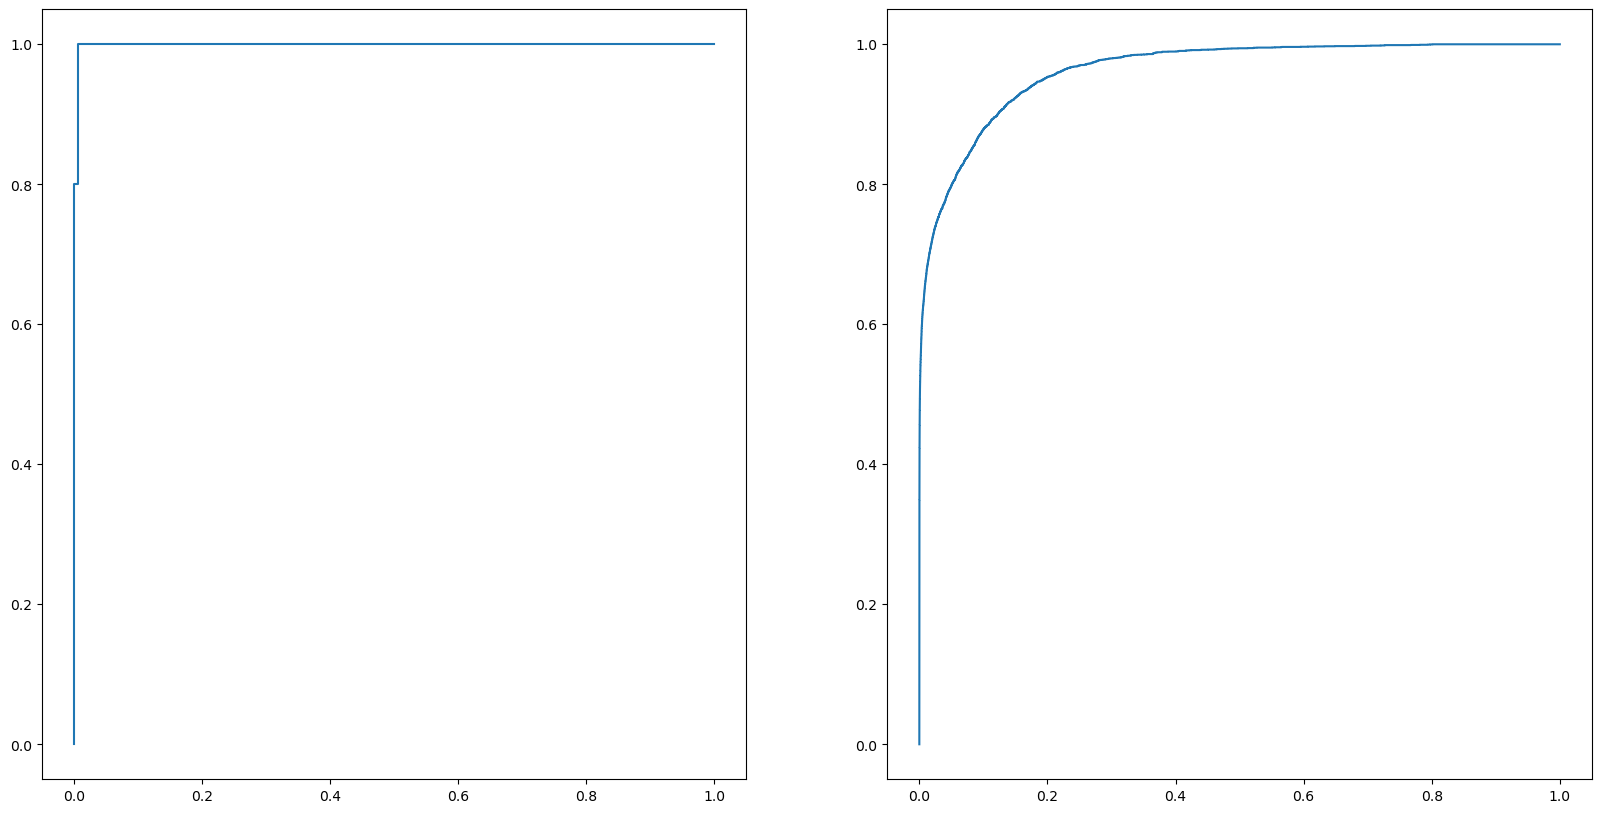

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# capture ROCAUC score
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig_img_rocauc = ax[0]
fig_pixel_rocauc = ax[1]

# calculate image-level ROC AUC score
fpr, tpr, img_thresholds = roc_curve(image_targets, anomaly_score)
img_roc_auc = roc_auc_score(image_targets, anomaly_score)

fpr_p, tpr_p, pixel_thresholds = roc_curve(image_masks.reshape(-1), anomaly_map.flatten())
pixel_roc_auc = roc_auc_score(image_masks.reshape(-1), anomaly_map.flatten())

print('target_name:{}\nimg_roc_auc:{:.1f}\nper_pixel_rocauc:{:.1f}\n'.format(target_name, img_roc_auc*100, pixel_roc_auc*100))

fig_img_rocauc.plot(fpr, tpr, label=f'AUROC = {img_roc_auc:.2f})')
# fig_img_rocauc.xlabel('False Positive Rate')
# fig_img_rocauc.ylabel('True Positive Rate')
# fig.title('img_ROC Curve target name:'+ target_name)

fig_pixel_rocauc.plot(fpr_p, tpr_p, label='%s img_ROCAUC: %.3f' % ('target_name', pixel_roc_auc))

save_path = os.path.join(save_dir, f'roc_{target_name}.jpg')    
plt.savefig(save_path, bbox_inches='tight', dpi=300)


In [7]:
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib

def plot_fig(test_img, scores, gts, threshold, save_dir, class_name, i):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    mean = np.array([0.485])
    std = np.array([0.229])


    # for i in range(num):
    img, mask, target,_  = test_img[i]
    # print(img)
    img = (((img.permute(1, 2, 0) * std) + mean) * 255.).to(torch.uint8)# denormalize


    # img = (((img * std) + mean) * 255.).astype(np.uint8) # denormalize
    # gt = gts[i].transpose(1, 2, 0).squeeze()
    gt = gts[i].squeeze()
    # heat_map = scores[i] * 255
    # mask = scores[i]
    heat_map = anomaly_map[i] * 255
    mask = anomaly_map[i]
    # mask[mask > threshold] = 1
    # mask[mask <= threshold] = 0
    mask = np.where(mask >= threshold, 1, 0)
    # kernel = morphology.disk(0)
    # mask = morphology.opening(mask, kernel)
    # mask *= 255
    # vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')

    img_np = img.cpu().numpy()  # Convert PyTorch tensor to NumPy array
    vis_img = mark_boundaries(img_np, mask, color=(1, 0, 0), mode='thick')
    fig_img, ax_img = plt.subplots(1, 4, figsize=(12, 3))
    fig_img.subplots_adjust(right=0.9)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    for ax_i in ax_img:
        ax_i.axes.xaxis.set_visible(False)
        ax_i.axes.yaxis.set_visible(False)
    ax_img[0].imshow(img, cmap='gray')
    ax_img[0].title.set_text('Image')
    ax_img[1].imshow(gt, cmap='gray')
    ax_img[1].title.set_text('GroundTruth')
    ax_img[2].imshow(mask, cmap='gray')
    ax_img[2].title.set_text('Predicted mask')    
    ax = ax_img[3].imshow(heat_map, cmap='jet', norm=norm)
    ax_img[3].imshow(img, cmap='gray', interpolation='none')
    ax_img[3].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
    ax_img[3].title.set_text('Predicted heat map')

    # ax_img[4].imshow(vis_img)
    # ax_img[4].title.set_text('Segmentation result')
    left = 0.92
    bottom = 0.15
    width = 0.015
    height = 1 - 2 * bottom
    rect = [left, bottom, width, height]
    cbar_ax = fig_img.add_axes(rect)
    cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
    cb.ax.tick_params(labelsize=8)
    font = {
        'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 8,
    }
    cb.set_label('Anomaly Score', fontdict=font)
    fig_img.savefig(os.path.join(save_dir, target_name + '_{}'.format(i)), dpi=300, bbox_inches='tight')
    plt.close()

    # fig_img.savefig(os.path.join(save_dir, class_name + '_{}'.format(i)), dpi=100)
    # plt.close()


# Normalization
max_score = anomaly_map.max()
min_score = anomaly_map.min()
scores = (anomaly_map - min_score) / (max_score - min_score)

# # capture ROCAUC score
# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# fig_img_rocauc = ax[0]
# fig_pixel_rocauc = ax[1]

# calculate image-level ROC AUC score
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(image_targets)

# fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % ("class_name", pixel_roc_auc))
# save_dir = '/content/MOEM-MemSeg/MemSeg-main/saved_model/MemSeg-carpet'
# os.makedirs(save_dir, exist_ok=True)
# threshold = 0.55

# get optimal threshold based Label
# distances = (tpr - 1.) ** 2 + fpr ** 2
# img_threshold = img_thresholds[np.argmin(distances)]

# gt_mask = np.asarray(gt_mask_list)
# precision, recall, thresholds = precision_recall_curve(image_masks.reshape(-1), scores.flatten())
precision, recall, thresholds = precision_recall_curve(image_masks.reshape(-1), anomaly_map.flatten())

a = 2 * precision * recall
b = precision + recall
f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
threshold = thresholds[np.argmax(f1)]
print(threshold)
# threshold = 3*threshold
img_num = 1
# # ====================================
# # SAVE RESULT oUTPUT IMAGES
# # ====================================

save_dir = fr'{os.getcwd()}\saved_model\{model_name}'
# with torch.no_grad():
for img_num in range(len(anomaly_map)):
    plot_fig(testset, scores, image_masks, threshold, save_dir, 'class_name', img_num)

0.18441324


<Figure size 640x480 with 0 Axes>

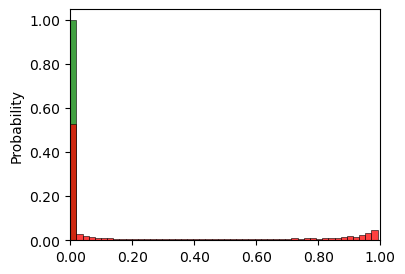

In [8]:
#####################################
# plot_anomaly_score_distributions
#####################################
import matplotlib.ticker as mtick
import seaborn as sns

# image_masks[image_masks > 0] = 255
# anomaly_map[anomaly_map > 0] = 255

ground_truths = np.stack(image_masks, axis=0)

N_COUNT = 100000

# for k, v in scores.items():
layer_score = np.stack(anomaly_map, axis=0)
normal_score = layer_score[ground_truths == 0]
abnormal_score = layer_score[ground_truths != 0]

plt.clf()
plt.figure(figsize=(4, 3))
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

with plt.style.context(['seaborn-v0_8-whitegrid']):
# with plt.style.context(['science', 'ieee', 'no-latex']):
    sns.histplot(np.random.choice(normal_score, N_COUNT), color="green", bins=50, label='${d(p_n)}$',
                    stat='probability', alpha=.75)
    sns.histplot(np.random.choice(abnormal_score, N_COUNT), color="red", bins=50, label='${d(p_a)}$',
                    stat='probability', alpha=.75)

plt.xlim([0, 1])

# plt.show()
save_path = os.path.join(save_dir, f'distributions_{target_name}.jpg')    
plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
# plt.savefig(save_dir, bbox_inches='tight', dpi=300)

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


predicted_scores  = np.array(anomaly_score)
true_labels = np.array(image_targets)


# fpr_p, tpr_p, pixel_threshold = roc_curve(image_mask.reshape(-1), anomaly_m.reshape(-1))
# precision, recall, thresholds = precision_recall_curve(image_masks.reshape(-1), anomaly_map.flatten())

precision, recall, thresholds = precision_recall_curve(image_targets, anomaly_score)
a = 2 * precision * recall
b = precision + recall
f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
threshold = thresholds[np.argmax(f1)]
# print(threshold)

# Calculate precision, recall, and F1-score
# Convert continuous scores to binary predictions based on the threshold
# threshold = 0.1
predicted_labels = np.where(predicted_scores  >= threshold, 1, 0)
# (predicted_scores  >= 0.5).astype(int)



target name: SL16
Precision: 0.94
Recall: 1.00
F1-score: 0.97
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       145
           1       0.94      1.00      0.97        15

    accuracy                           0.99       160
   macro avg       0.97      1.00      0.98       160
weighted avg       0.99      0.99      0.99       160



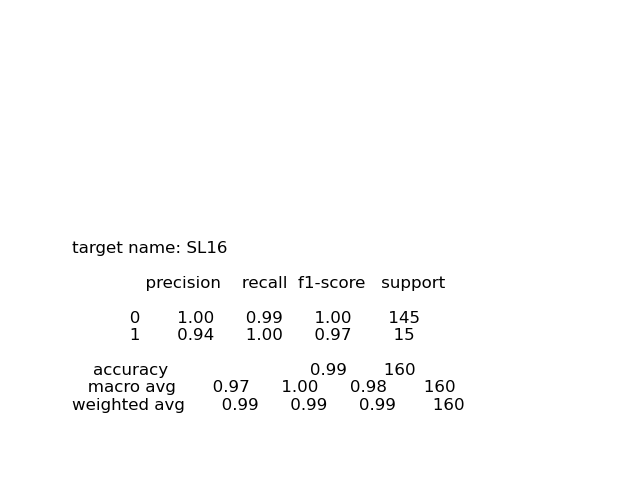

In [10]:
import matplotlib.pyplot as plt

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
    
    # return precision, recall, f1
print("target name:", target_name)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

report = classification_report(true_labels, predicted_labels)
print(report)



# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Add text to the figure
ax.text(0.1, 0.5, f"target name: {target_name}\n\n" + report, va='top', wrap=True, fontsize=12)

# Remove axes and save the figure
ax.axis('off')
plt.savefig('classification_metrics.png', bbox_inches='tight')
save_path = os.path.join(save_dir, f'F1-score_{target_name}.jpg')    
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()



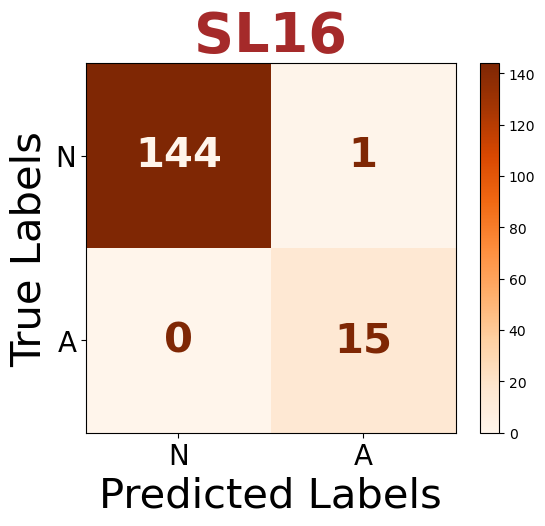

In [11]:
# Generate confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
target_names = ['N','A']
cm = confusion_matrix(true_labels, predicted_labels)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
# Plot with Customizations
fig, ax = plt.subplots()  # Larger figure size for better visibility
disp.plot(ax=ax, cmap='Oranges')
# disp.plot(ax=ax, cmap='Greens', colorbar=False)  # Change color map to 'Greens'

plt.title(target_name, fontsize=40, fontweight='bold', color='brown')

ax.set_xlabel("Predicted Labels", fontsize=30)
ax.set_ylabel("True Labels", fontsize=30)
ax.tick_params(axis='both', labelsize=20)

# Annotate with Larger Font
for text in ax.texts:
    text.set_fontsize(30)
    text.set_fontweight('bold')
    
# plt.title('target name: '+ target_name, fontsize=50, fontweight='bold')
plt.savefig('classification_metrics.png', bbox_inches='tight')
save_path = os.path.join(save_dir, f'classification_metrics_{target_name}.jpg')    
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

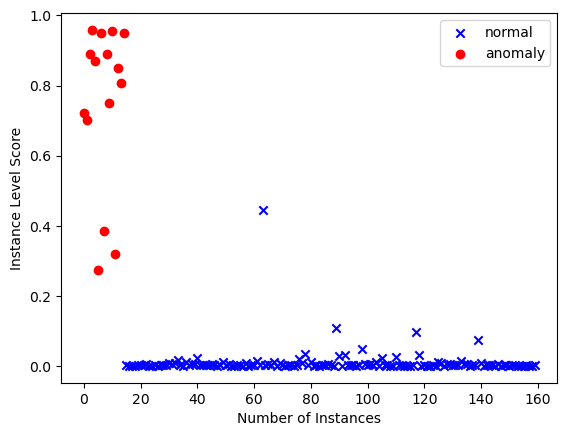

In [12]:
normalIndx = np.where(true_labels==0)
anomalyIndx = np.where(true_labels==1)
normalscr = predicted_scores[normalIndx]
anomalyscr = predicted_scores[anomalyIndx]

plt.scatter(normalIndx, normalscr, color='blue', marker='x', label='normal')
plt.scatter(anomalyIndx,anomalyscr, color='red', marker='o', label='anomaly') 
plt.xlabel('Number of Instances') 
plt.ylabel('Instance Level Score') 
plt.legend()
save_path = os.path.join(save_dir, f'Instances distribution_{target_name}.jpg')    
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()